In [1]:
import numpy as np
import os
import proplot as pplt #replace this with matplotlib.pyplot if you'd like - i really like proplot though!!
import pandas as pd
import pickle
import keras
import joblib

In [32]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


import matplotlib
import matplotlib.cm as cm
pd.options.display.precision = 2
pd.set_option('display.colheader_justify', 'center')

It's important to check that your ML actually worked! Best practice is to generate a separate test set in the same sampling bounds, and pass this independent test set through your NN.

When we did the NN training, we did a train-test-split, using 80% of the original simulations to train the NN and 20% to check how well it performs on data it wasn't trained on.
<!-- Below, I've skipped this step and just split the original simulation set into the exact subset that was used to train the NN  -->

In [ ]:
sampling_bounds = pd.read_csv('10_training_set_params/sampling_bounds.csv',sep=',',index_col=0)
pplt.rc.cycle = '538'

First, we look at the training and testing metrics

In [8]:
test_metrics = pd.read_csv('42_models/ANN_all_training_metrics_augmented_features_8x_100mV.csv',sep=',',index_col=0)

display(pd.pivot_table(test_metrics.loc[test_metrics.set=='Train'],index='metric_name',columns='parameter',values='metric_value'))
display(pd.pivot_table(test_metrics.loc[test_metrics.set=='Test'],index='metric_name',columns='parameter',values='metric_value'))

parameter,AML_ADJ,DF_A,I0_A
metric_name,,,
MAE,6.90e-03,7.65e-02,3.71e-02
MAPE,9.21e-03,6.46e-03,5.34e-03
MaxE,8.25e-02,7.35e-01,3.15e-01
R2,9.95e-01,9.73e-01,9.91e-01
RMSE,9.93e-03,1.11e-01,5.31e-02


parameter,AML_ADJ,DF_A,I0_A
metric_name,,,
MAE,7.35e-03,8.29e-02,3.70e-02
MAPE,9.74e-03,7.00e-03,5.31e-03
MaxE,8.24e-02,5.94e-01,3.40e-01
R2,9.94e-01,9.70e-01,9.91e-01
RMSE,1.11e-02,1.18e-01,5.23e-02


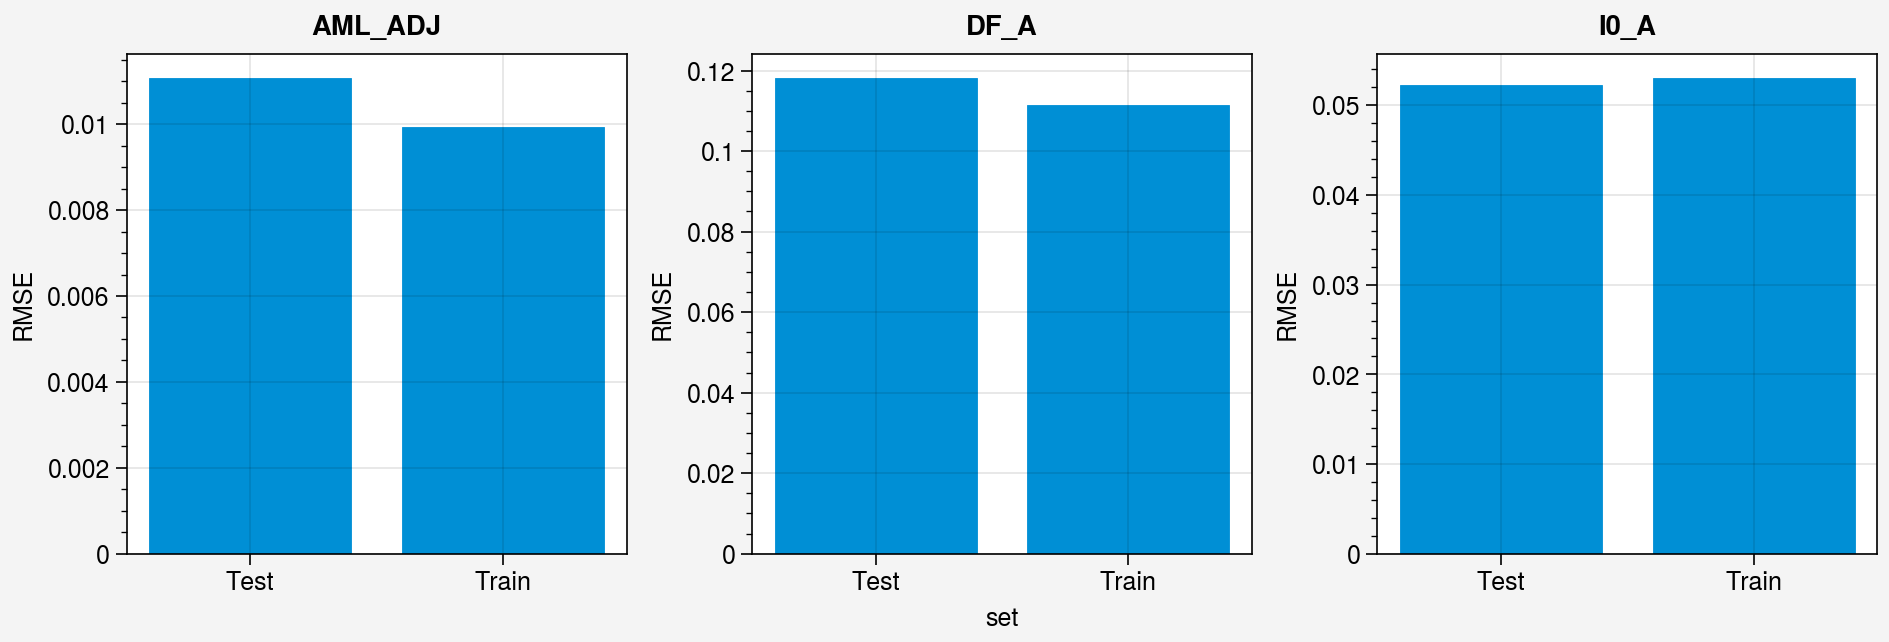

In [46]:
metric='RMSE'

fig,axs = pplt.subplots(nrows=1,ncols=len(test_metrics.parameter.unique()),sharey=False)

for p,ax in zip(test_metrics.parameter.unique(),axs):
    p_results = pd.pivot_table(test_metrics.loc[test_metrics.parameter==p],index='metric_name',columns='set',values='metric_value')
    ax.bar(p_results.loc[metric,:])
    
axs.format(toplabels=list(test_metrics.parameter.unique()))

In [52]:
def plot_predictions_ann_all(feature_filename,X,axs,y_true,color_sc=False,color='blue',color_col=None,cmap='viridis',label=None,alpha=0.5):
    model_path = f'42_models/all/ANN_{feature_filename}.h5'
    model = keras.models.load_model(model_path)
    scaler_path = f"42_models/all/scaler_{feature_filename}.save"
    scaler = joblib.load(scaler_path) 

    y_pred = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred)
    print(np.shape(y_pred))
    max_residuals = []
    for i,p in enumerate(ps):
        if color_sc:
            sc = axs[i].scatter(y_true[p].values,y_pred.T[i],c=y_true[color_col],cmap=cmap,label=label,alpha=alpha,s=7)
            
        else:
            axs[i].scatter(y_true[p].values,y_pred.T[i],label=label,alpha=alpha,s=7,color=color)
            sc = None
        max_residuals.append(np.max(np.abs(y_true[p].values-y_pred.T[i])))
    return sc #,max_residuals

ws = 0.05*(sampling_bounds['ub']-sampling_bounds['lb'])

def plot_residuals_ann_all(feature_filename,X,axs,y_true,widths=0.05*(sampling_bounds.loc[targets.columns,'ub']-sampling_bounds.loc[targets.columns,'lb']),color='blue',label=None,alpha=0.5):
    model_path = f'42_models/all/ANN_{feature_filename}.h5'
    model = keras.models.load_model(model_path)
    scaler_path = f"42_models/all/scaler_{feature_filename}.save"
    scaler = joblib.load(scaler_path) 

    y_pred = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred)

    for i,p in enumerate(ps):
        residuals = -1*y_true[p].values+y_pred.T[i]
        axs[i].hist(residuals,label=label,bins=int(np.ceil((residuals.max() - residuals.min())/widths[i])),color=color)
        
def get_iteration(filepath):
    iterations = []
    for file in os.listdir(filepath):
        if file.startswith('Simulation_Parameters'):
            iterations.append(int(file.split('_I')[1].split('.')[0]))
    return np.max(iterations)

Next, we'll plot how the actual predictions look compared to the true values. We can get the exact same train-test split as was used when training the neural network by setting `random_state` to the same number as in `41_ann_all.py`, which was set to `42`.

In [57]:
feature_filename = 'augmented_features_8x_100mV'

it = get_iteration('10_training_set_params/')
sim_params = pd.read_csv(f'10_training_set_params/Simulation_Parameters_I{it}.csv',sep=',',index_col=0)
sim_params = sim_params.loc[sim_params.index.isin(features.index)]
targets = pd.read_csv(f'10_training_set_params/targets_I{it}.csv',sep=',',index_col=0)
targets = targets.loc[targets.index.isin(features.index)]
ps = targets.columns.values

filename = f'30_sim_features/features_100mV.csv'
X_df = pd.read_csv(filename,sep=',',index_col=0)

X_train, X_test, y_train, y_test = train_test_split(X_df.values, sim_params, test_size=0.20, random_state = 42)

# plot prediction vs truth

(565, 3)
(142, 3)


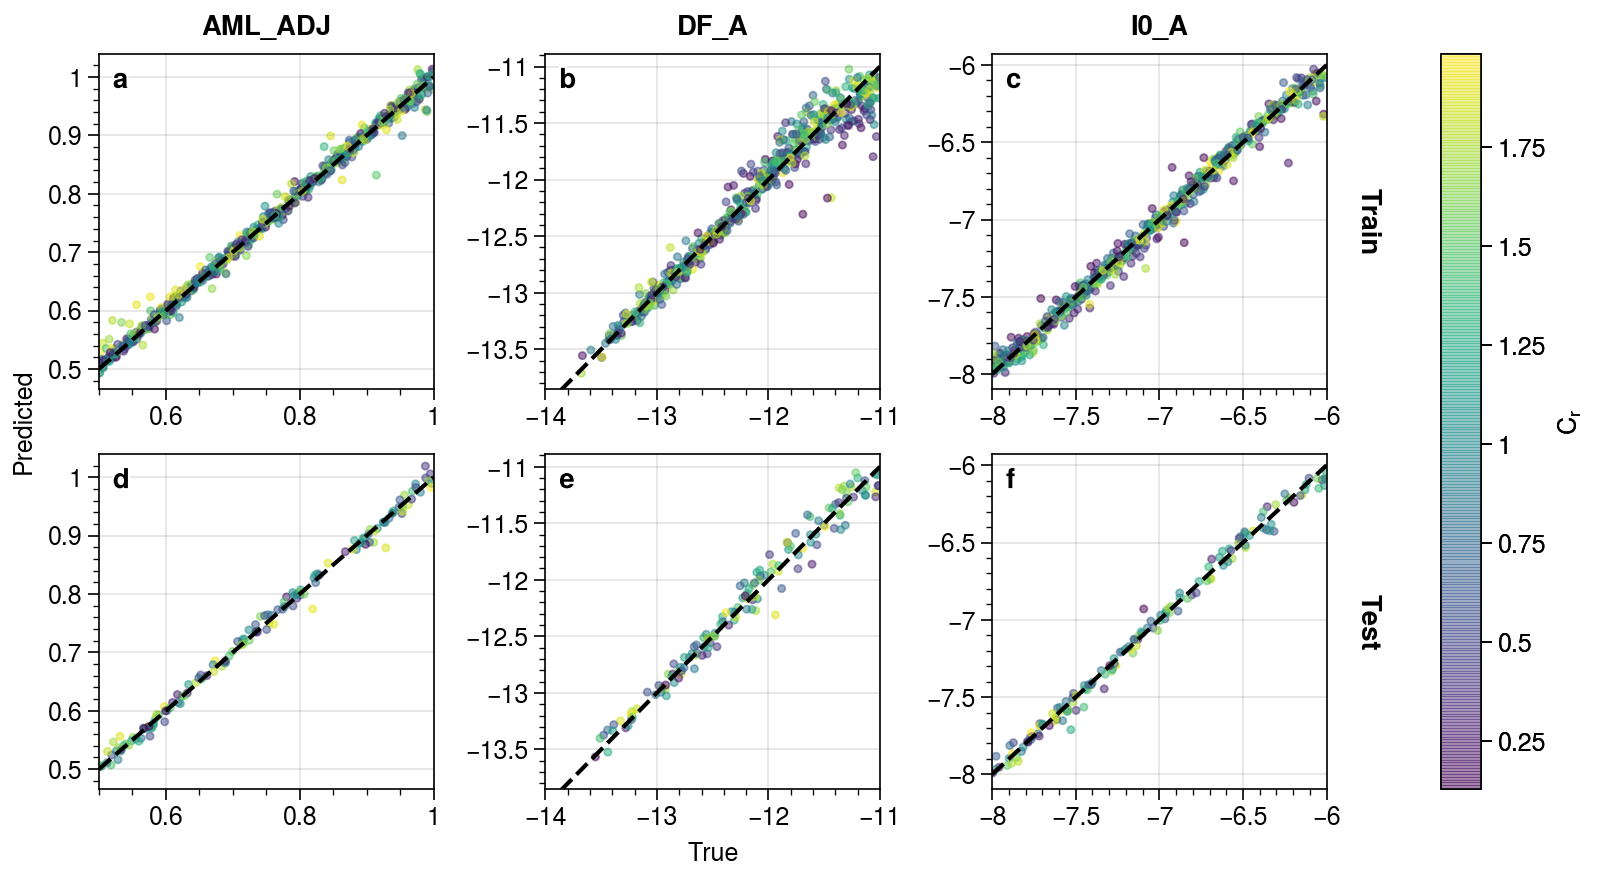

In [41]:
fig,axs = pplt.subplots(nrows=2,ncols=len(ps),facecolor='w',sharey=1,sharex=1,aspect=1,width=8)

sc = plot_predictions_ann_all(feature_filename,X_train,axs[0,:],y_train,color_sc=True,color_col='CRATE')
sc = plot_predictions_ann_all(feature_filename,X_test,axs[1,:],y_test,color_sc=True,color_col='CRATE')


for i,p in enumerate(ps):
    axs[:,i].format(xlim=(sampling_bounds.loc[p,'lb'],sampling_bounds.loc[p,'ub']),
              ylim=(np.min(np.min(axs[0,i].get_ylim())),np.max(axs[0,i].get_ylim())))
    for ax in axs[:,i]:
        ax.plot(np.linspace(sampling_bounds.loc[p,'lb'],sampling_bounds.loc[p,'ub'],100),np.linspace(sampling_bounds.loc[p,'lb'],sampling_bounds.loc[p,'ub'],100),'--k')

axs.format(xlabel='True',ylabel='Predicted',
           toplabels=list(ps),rightlabels=['Train','Test'],rightlabels_kw={'rotation':-90},
           abc=True,abcloc='ul')
fig.colorbar(sc,pad=4,label='$C_r$')
pplt.show()

# plot residuals

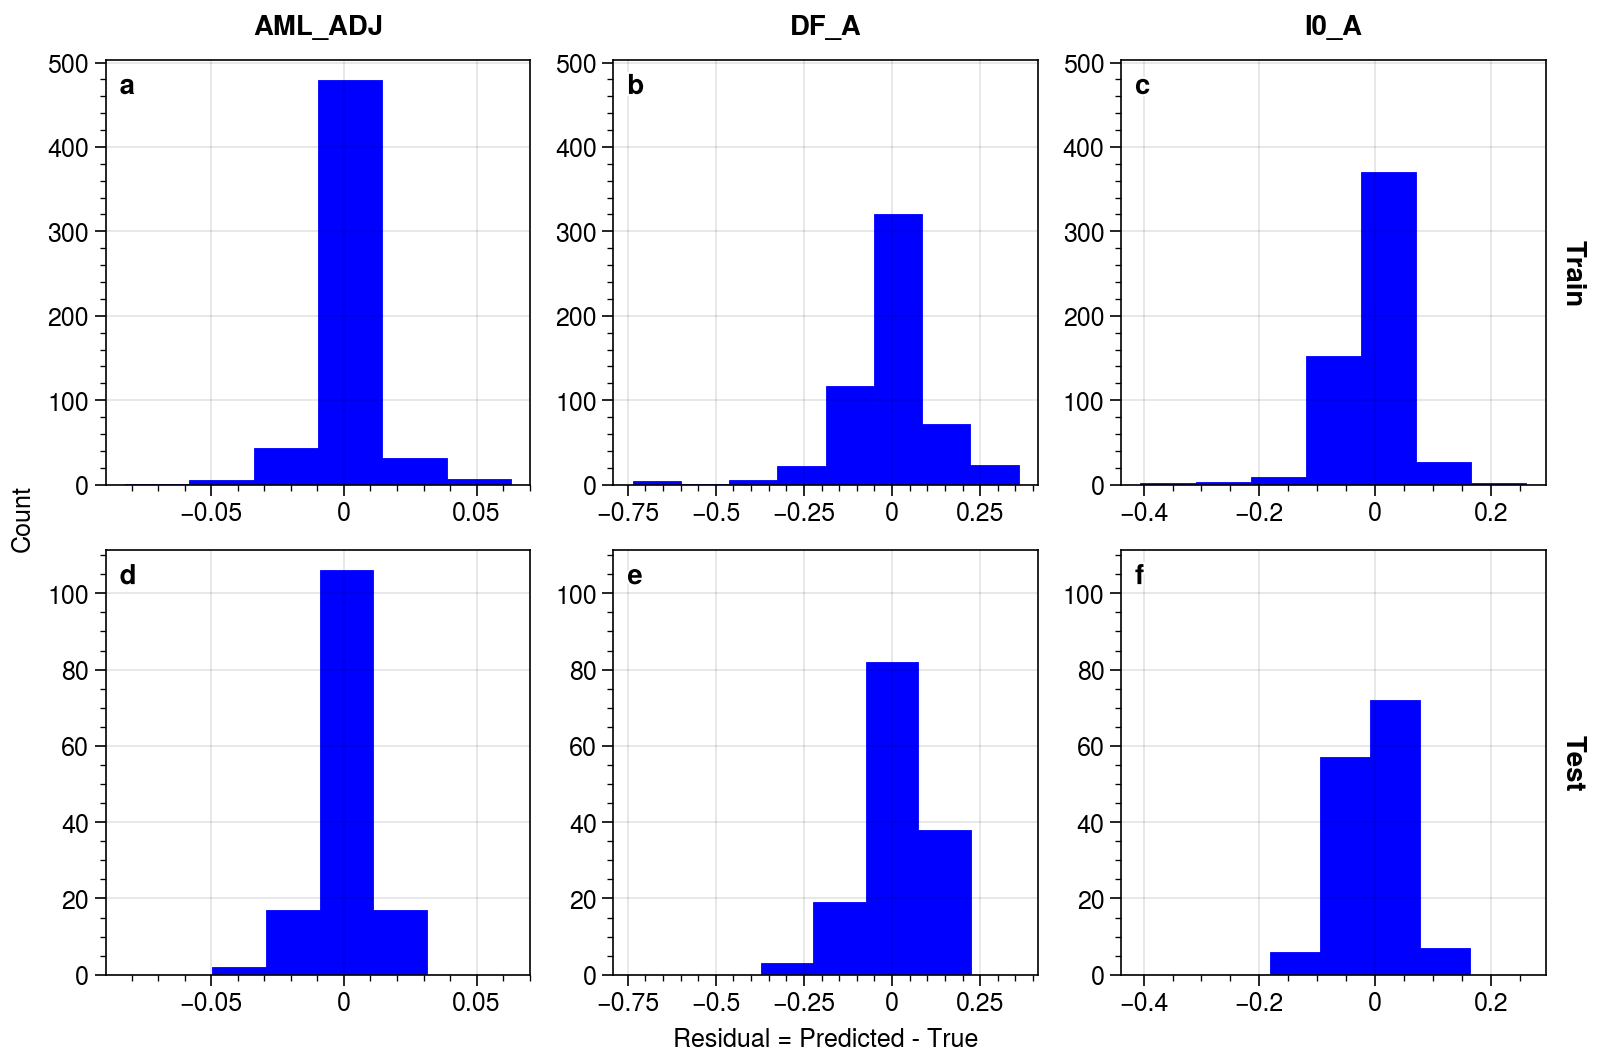

In [56]:
fig,axs = pplt.subplots(nrows=2,ncols=len(ps),facecolor='w',sharey=2,sharex=2,aspect=1,width=8)

sc = plot_residuals_ann_all(feature_filename,X_train,axs[0,:],y_train)
sc = plot_residuals_ann_all(feature_filename,X_test,axs[1,:],y_test)

axs.format(xlabel='Residual = Predicted - True',ylabel='Count',
           toplabels=list(ps),rightlabels=['Train','Test'],rightlabels_kw={'rotation':-90},
           abc=True,abcloc='ul')
pplt.show()